In [1]:
"""
#### Code adapted from the source code of ArtEmis dataset paper
"""

import json
import torch
import pandas as pd
import os.path as osp
import numpy as np
import itertools
from PIL import Image
from model.func_eval import unpickle_data,torch_load_model
from artemis.utils.vocabulary import Vocabulary #Use for text2emotion metrics
from artemis.evaluation.single_caption_per_image import apply_basic_evaluations
from artemis.emotions import IDX_TO_EMOTION
%load_ext autoreload
%autoreload 2

In [2]:
DBdir = "../Dataset/ArtEmis/ArtEmis"
modelname = 'CLIPViTB16_1Gen' 
model_dir = f'output/Ours_ArtEmis/{modelname}'


In [3]:
references_file = osp.join(DBdir,'Artemis_GT.pkl')
split = 'test'
gpu_id = 0

# the evaluation of the longest-common-subsequence is quite slow -- so we sub-sampled the data:
default_lcs_sample = [25000, 800]
# First integer (25000) = number of training (gt) sentences to subsample from all training
# Secong integer (800)  = number of sample sentences to subsample from all generations

In [4]:
device = "cpu"
evaluation_methods = {'bleu', 'meteor', 'rouge', 'spice','cider'}
print(evaluation_methods) 

{'cider', 'bleu', 'meteor', 'rouge', 'spice'}


In [5]:
from model.count_IdC import count_IdC

In [6]:
print("Evaluating on ArtEmis...")
gt_data = next(unpickle_data(references_file))
train_utters = gt_data['train']['references_pre_vocab']
train_utters = list(itertools.chain(*train_utters))  # undo the grouping per artwork to a single large list
print('Training Utterances', len(train_utters))
unique_train_utters = set(train_utters)
gt_data = gt_data[split]
print('Images Captioned', len(gt_data))

sampled_captions_file = osp.join(model_dir,'fullDB_test_BS2.pkl')
saved_samples = next(unpickle_data(sampled_captions_file))
for sampling_config_details, captions in saved_samples:  # you might have sampled under several sampling configurations
    merged = pd.merge(gt_data, captions)  # this ensures proper order of captions to gt (via accessing merged.captions)
    merged['caption'] = merged.captions_predicted

Evaluating on ArtEmis...
Training Utterances 348197
Images Captioned 5497


Evaluating on ArtEmis literal captions ...
4666


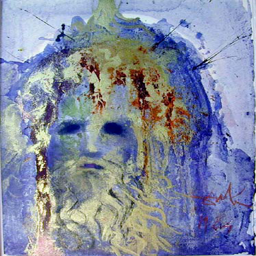

Generated caption: the face looks like it is melting into the eyes 
Ground-truth captions: ['this is like a ghost but comforting with the blues', 'i feel some sense of dread i recognize the general form to be christ i think but it looks so different than what i had normally think christ to look like that it leaves me feeling uneasy', 'the man looks like he has blood on his face and it looks scary', 'the figures pale blue face looks as if it has been frozen in ice', 'the person looks like a ghost or zombie from a horror film', 'i am sad to see the torture and what looks like blood all over the canvas', "the odd beard strands look like people growing out of the man 's face", 'the subject looks like the face of jesus with blood dripping down his face', 'the blank expression and lack of eyes portray this man as soulless and its feel is enhanced by the gloomy colors used', 'the powerful and striking eyes pull you into the vivid image'] 

1862


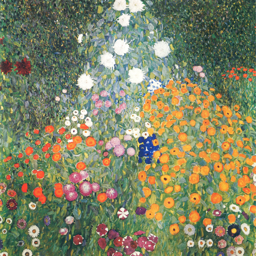

Generated caption: the bright colors of the flowers are beautiful 
Ground-truth captions: ['this serene field of flowers has many bright and vivid colors that flow so well together and makes you feel as though you are in another world', 'the bright colors on the flowers look like a happy spring day', 'i am not liking the lack of talent here i do not like the lack of detail that was put into the flowers the measurements seem to be too off', 'this feels like a warm sunny day in a garden surrounded by the gentle perfume of flowers', 'it is a field of flowers with a nice range of color with nobody around this seems like it would be a nice area to relax and be carefree', 'it reminds me of an english garden full of flowers in bloom very cheerful', 'i feel joy looking at this painting the color in the leaves and grass bring an instant <unk> of <unk> the greens yellows and blues meld so perfectly the flowers themselves are gorgeous and make me feel as though i am in the field myself', 'the man

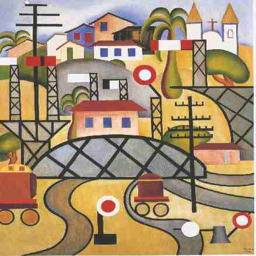

Generated caption: the colors are bright and playful 
Ground-truth captions: ['the suppleness of the shapes used for the objects reminds me of toy cars and those rugs that are made to look like maps', 'it looks like a puzzle game that makes me think of it', 'makes me feel like i am looking at a newly built modern city in an old desert city', 'this piece reminds me of a childhood tv show with the bright colors and the rail carts and all the different traffic signs i love the block work to the city as if your expecting a cartoon train to come around the corner', 'i want to visit this town it looks like <unk> fun place', 'the simplified geometric shapes that are more representational than realistic make this scene seem childlike and fun which i find amusing', 'the building is too simple and relies largely on geometric shapes', 'the bright colors are happy blue sky is cheerful', 'i am not a fan of this because i think the harsh lines and contrasting colors are too jarring', 'i like all of 

In [7]:
merged = merged.sort_values(by=['painting'])
merged.reset_index(inplace=True, drop=True)
print("Evaluating on ArtEmis literal captions ...")
img_dir = '../Dataset/ArtEmis/OriginalArtEmis/wikiart/'
for random_id in [4666,1862,4854]:
    print(random_id)
    row = merged.iloc[random_id]
    img_file = osp.join(img_dir, row['art_style'], row['painting'] + '.jpg')
    image = Image.open(img_file).resize((256, 256))
    display(image)
    print("Generated caption:",row['caption'],
          "\nGround-truth captions:",row['references'],"\n") 